In [1]:
import pandas as pd
import csv

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import gensim
from gensim.models import TfidfModel
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

from tqdm import tqdm
import logging

from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import torch.optim as optim
import torch

import random

In [2]:
SEED = 54321
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
def parse_stories_to_csv(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    current_story = None
    current_year = None
    current_contents = []

    all_stories = []

    for line in lines:
        line = line.strip()

        if line == "Return to Table of Contents":
            if current_story and current_year and current_contents:
                contents_string = '\n'.join(current_contents)
                all_stories.append([current_story, current_year, contents_string])
            current_story = None
            current_year = None
            current_contents = []
        
        elif not current_story:
            current_story = line
        
        elif not current_year:
            if line.startswith("(") and line.endswith(")"):
                current_year = line.strip("()")
        
        else:
            current_contents.append(line)

    if current_story and current_year and current_contents:
        contents_string = '\n'.join(current_contents)
        all_stories.append([current_story, current_year, contents_string])

    with open(output_file, 'w', newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['Story Name', 'Year', 'Contents'])
        writer.writerows(all_stories)

input_file = 'HPLovecraft_complete.txt'
output_file = 'lovecraft_stories.csv'


parse_stories_to_csv(input_file, output_file)


In [4]:
# csv_file = 'lovecraft_stories.csv'

# df = pd.read_csv(csv_file)

# df

In [5]:
# nlp = spacy.load('en_core_web_lg')

# csv_file = 'lovecraft_stories.csv'

# df = pd.read_csv(csv_file)

# def process_text(text):
#     doc = nlp(text)
#     processed_tokens = [token.text for token in doc]
#     return processed_tokens

# df['Tokens'] = df['Contents'].apply(nlp)

# df


In [6]:
# Load spaCy English language model
#!!!ADDED Pparser and ner back
nlp = spacy.load('en_core_web_lg', 
    #  disable=['parser', 'ner']
)

# Function to preprocess text for topic modeling
def preprocess_text(text):
    # Tokenize and lemmatize text using spaCy
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_.lower() not in STOP_WORDS]
    return tokens

# Read the CSV file into a pandas DataFrame
csv_file = 'lovecraft_stories.csv'
df = pd.read_csv(csv_file)

df['Tokens'] = df['Contents'].apply(nlp)
# Apply preprocessing to the 'Contents' column
df['Processed Tokens'] = df['Contents'].apply(preprocess_text)

In [7]:
print(
    df[["Year", "Story Name"]]
    .groupby("Year", as_index=False)["Story Name"]
    .apply(lambda column: ',  '.join(f'"{name}"' for name in column)).rename(columns={"Story Name": "Stories"})
    .to_markdown(index=None)
)

|   Year | Stories                                                                                                                                                                                                                                                              |
|-------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|   1917 | "The Tomb",  "Dagon"                                                                                                                                                                                                                                                 |
|   1918 | "Polaris"                                                                                                                                                              

### Yearly Statistics

Most Common Words per Year

In [8]:
from collections import Counter

grouped = df.groupby('Year')

def find_common_words(group):
    word_counts = Counter()
    for tokens in group['Processed Tokens']:
        word_counts.update(tokens)
    return word_counts.most_common(5)

common_words_by_year = grouped.apply(find_common_words)


C:\Users\SB\AppData\Local\Temp\ipykernel_13448\2765516821.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  common_words_by_year = grouped.apply(find_common_words)


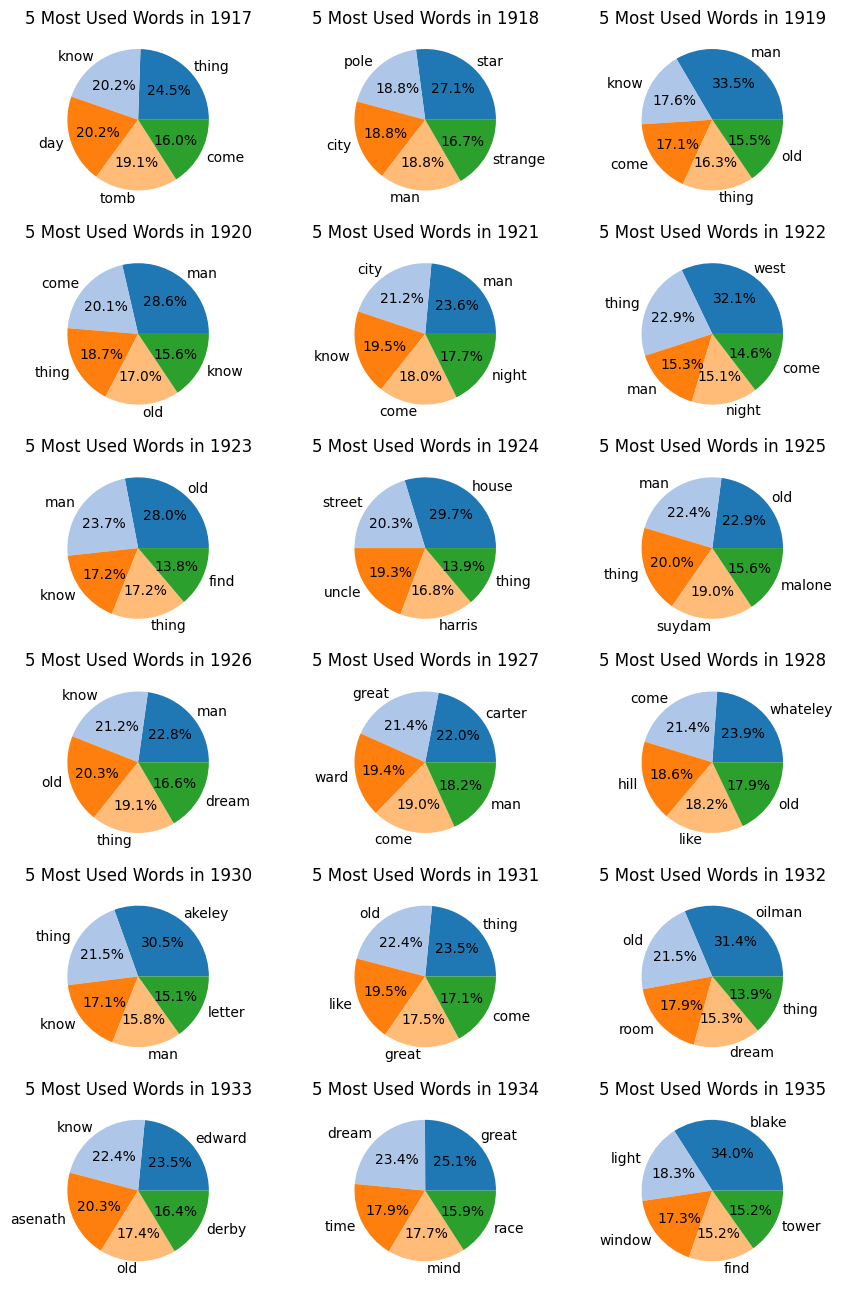

In [9]:
plt.figure(figsize=(9, 13)) 
colors = plt.cm.tab20.colors 

num_years = len(common_words_by_year)
num_rows = (num_years + 2) // 3 
num_cols = min(num_years, 3)

for i, (year, common_words) in enumerate(common_words_by_year.items()):
    words, counts = zip(*common_words)
    top_words = words[:5]
    top_counts = counts[:5]

    plt.subplot(num_rows, num_cols, i+1)  
    plt.pie(top_counts, labels=top_words, autopct='%1.1f%%', colors=colors)
    plt.title(f"5 Most Used Words in {year}")

plt.tight_layout()
plt.show()


In [10]:
# bigrams and trigrams
bigrams_phrases = gensim.models.Phrases(df['Processed Tokens'].to_list(), min_count=5, threshold=15)
trigrams_phrases = gensim.models.Phrases(bigrams_phrases[df['Processed Tokens'].to_list()], threshold=15)

bigram = gensim.models.phrases.Phraser(bigrams_phrases)
trigram = gensim.models.phrases.Phraser(trigrams_phrases)


def make_bigrams(texts):
    return tuple(bigram[doc] for doc in texts)
    
def make_trigrams(texts):
    return tuple(trigram[doc] for doc in texts)


data_bigrams = make_bigrams(df['Processed Tokens'].to_list())
data_bigrams_trigrams = make_trigrams(data_bigrams)

df['Processed Bigrams Trigrams'] = data_bigrams_trigrams

# pprint(tuple(x for x in data_bigrams_trigrams[1] if "_" in x))

In [11]:
# Create dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(df['Processed Bigrams Trigrams'])
# dictionary.filter_extremes(no_below = 0, no_above = 0.6)
corpus = [dictionary.doc2bow(tokens) for tokens in df['Processed Bigrams Trigrams']]

tfidf = TfidfModel(corpus=corpus, id2word=dictionary)

low_value = 0.03
words = list()
words_missing_in_tfidf = list()
for i in range(len(corpus)):
    bow = corpus[i]
    # low_value_words = list()
    
    tfidf_ids = [id for (id, value) in tfidf[bow]]
    bow_ids = [id for (id, value) in bow]
    low_value_words = [id for (id, value) in tfidf[bow] if value < low_value]
    
    drops = low_value_words + words_missing_in_tfidf
    
    words.extend(dictionary[item] for item in drops)
    
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [12]:
from collections import Counter

grouped = df.groupby('Year')

def find_common_bigrams_trigrams(group):
    word_counts = Counter()
    # print(group['Processed Bigrams Trigrams'])
    for tokens in group['Processed Bigrams Trigrams']:
        tokens = [token for token in tokens if "_" in token]
        word_counts.update(tokens)
    return word_counts.most_common(5)

common_bigrams_trigrams_by_year = grouped.apply(find_common_bigrams_trigrams)


C:\Users\SB\AppData\Local\Temp\ipykernel_13448\3352908320.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  common_bigrams_trigrams_by_year = grouped.apply(find_common_bigrams_trigrams)


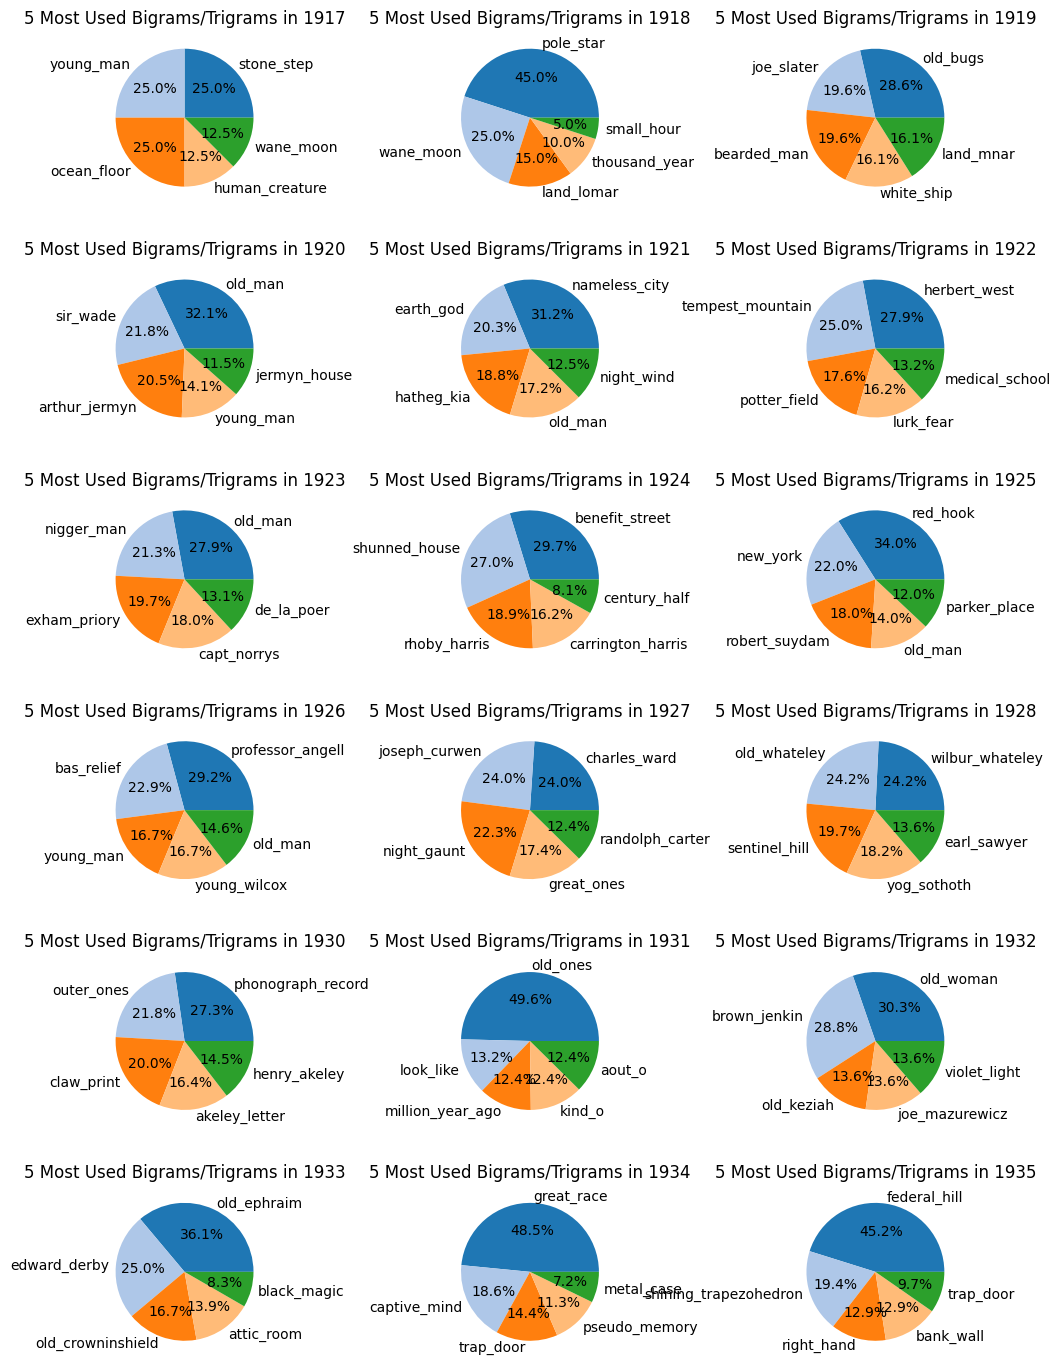

In [13]:
plt.figure(figsize=(10, 14)) 
colors = plt.cm.tab20.colors 

num_years = len(common_bigrams_trigrams_by_year)
num_rows = (num_years + 2) // 3 
num_cols = min(num_years, 3)

for i, (year, common_words) in enumerate(common_bigrams_trigrams_by_year.items()):
    words, counts = zip(*common_words)
    top_words = words[:5]
    top_counts = counts[:5]

    plt.subplot(num_rows, num_cols, i+1)  
    plt.pie(top_counts, labels=top_words, autopct='%1.1f%%', colors=colors)
    plt.title(f"5 Most Used Bigrams/Trigrams in {year}")

plt.tight_layout()
plt.show()


In [14]:
from collections import Counter

grouped = df.groupby('Year')

def find_common_pos(group):
    word_counts = Counter()
    for tokens in group['Tokens']:
        POSs = [spacy.explain(token.pos_) for token in tokens]
        word_counts.update(POSs)
    return word_counts.most_common(5)

common_pos_by_year = grouped.apply(find_common_pos)

C:\Users\SB\AppData\Local\Temp\ipykernel_13448\4222153023.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  common_pos_by_year = grouped.apply(find_common_pos)


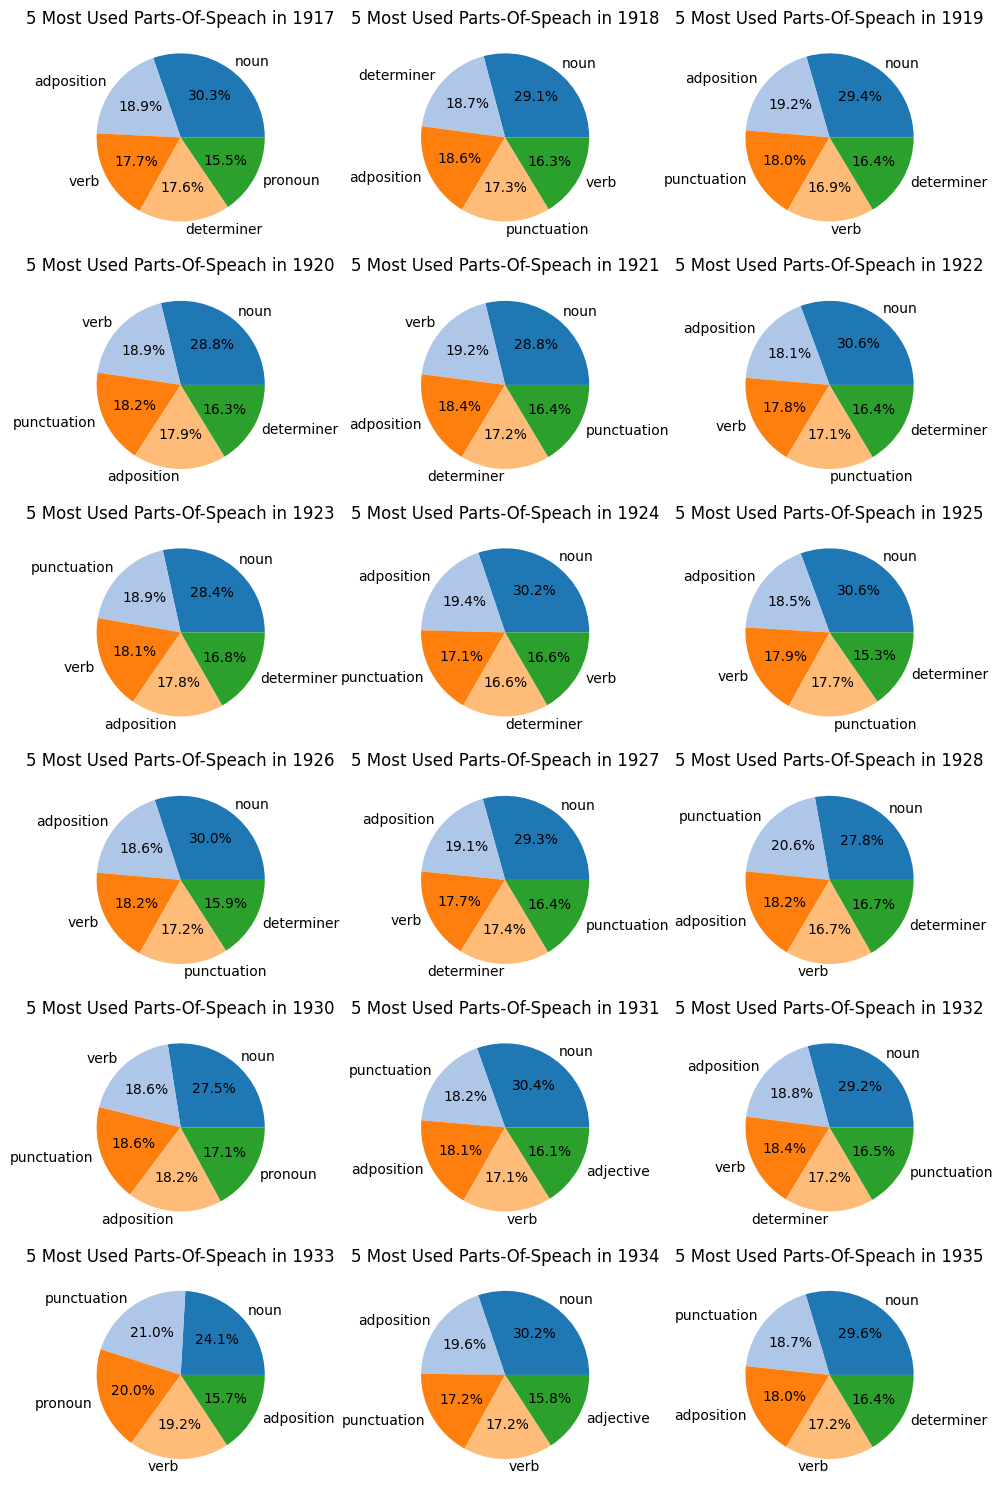

In [15]:
plt.figure(figsize=(10, 15)) 
colors = plt.cm.tab20.colors 

num_years = len(common_bigrams_trigrams_by_year)
num_rows = (num_years + 2) // 3 
num_cols = min(num_years, 3)

for i, (year, common_words) in enumerate(common_pos_by_year.items()):
    words, counts = zip(*common_words)
    top_words = words[:5]
    top_counts = counts[:5]

    plt.subplot(num_rows, num_cols, i+1)  
    plt.pie(top_counts, labels=top_words, autopct='%1.1f%%', colors=colors)
    plt.title(f"5 Most Used Parts-Of-Speach in {year}")

plt.tight_layout()
plt.show()


Most Common Structures per Year

In [16]:
# from tabulate import tabulate

# table_data = []

# for year, common_words in common_words_by_year.items():
#     for word, count in common_words:
#         table_data.append([year, word, count])

# headers = ["Year", "Word", "Count"]
# print(tabulate(table_data, headers=headers))

In [17]:
# Print the first few items in the processed DataFrame
print(df.head())

# Print the dictionary and first few items in the corpus
print("Dictionary:")
print(dictionary.token2id)

print("\nCorpus:")
for doc in corpus[:5]:
    print(doc)

                 Story Name  Year  \
0                  The Tomb  1917   
1                     Dagon  1917   
2                   Polaris  1918   
3  Beyond the Wall of Sleep  1919   
4                    Memory  1919   

                                            Contents  \
0  \nIn relating the circumstances which have led...   
1  \nI am writing this under an appreciable menta...   
2  \nInto the north window of my chamber glows th...   
3  \n"/ have an exposition of sleep come upon me....   
4  \nIn the valley of Nis the accursed waning moo...   

                                              Tokens  \
0  (\n, In, relating, the, circumstances, which, ...   
1  (\n, I, am, writing, this, under, an, apprecia...   
2  (\n, Into, the, north, window, of, my, chamber...   
3  (\n, ", /, have, an, exposition, of, sleep, co...   
4  (\n, In, the, valley, of, Nis, the, accursed, ...   

                                    Processed Tokens  \
0  [relate, circumstance, lead, confinement, re

In [18]:
# logging.disable(logging.NOTSET)
logging.disable(logging.CRITICAL)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                   level=logging.DEBUG,
                   filename='log.log')

import os
import json
coherence_scores_path = "coherence_scores.json"
if os.path.isfile(coherence_scores_path):
    with open(coherence_scores_path) as coherence_scores_file:
        coherence_scores = json.load(coherence_scores_file)
        coherence_scores = dict(map(lambda pair: (int(pair[0]), pair[1]), coherence_scores.items(),))
else:
    coherence_scores = dict()

In [19]:
def calc_coherence_scores(topic_nums):
    max_coherence_score = max([*coherence_scores.values(), -1])
    
    for num_topics in (bar := tqdm(set(topic_nums) - set(coherence_scores.keys()), position=0, leave=True)):
        # Build LDA model
        lda_model = models.LdaModel(corpus, id2word=dictionary, random_state=42, 
            num_topics=num_topics, 
            passes=10, 
            iterations=60, 
            chunksize=len(corpus),
            eval_every=None,
        )
        
        coherencemodel = CoherenceModel(model=lda_model, texts=df['Processed Bigrams Trigrams'].to_list(), dictionary=dictionary, coherence='c_v')
        
        prev_coherence_score = coherencemodel.get_coherence()
        max_coherence_score = max(max_coherence_score, prev_coherence_score)
        
        coherence_scores[num_topics] = prev_coherence_score
        
        bar.set_description(f"{prev_coherence_score = :.2}, {max_coherence_score = :.2}")

In [20]:
calc_coherence_scores( (2, 5, 7, 16, 17, 18, 19, 21, 22) + tuple(range(10, 75 + 1, 5)))

0it [00:00, ?it/s]


In [21]:
with open(coherence_scores_path, "w") as coherence_scores_file:
    json.dump(dict(sorted(coherence_scores.items())), coherence_scores_file, indent=4)

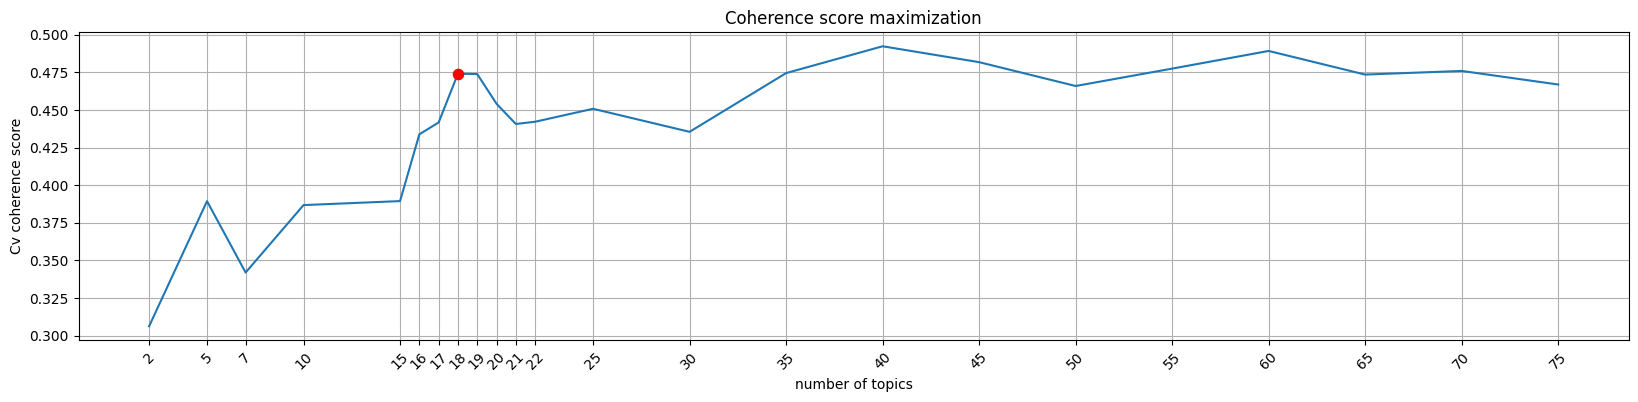

In [22]:
from matplotlib.pyplot import figure

figure(figsize=(20, 4))

temp = np.array(list(sorted(coherence_scores.items(), key=lambda x: int(x[0]))))

plt.plot(temp[:,0],temp[:,1])
plt.scatter(18, coherence_scores[18], s=40, marker='o', facecolors='r', edgecolors='r', linewidths=2, zorder=10)

plt.ylabel("Cv coherence score")
plt.xlabel("number of topics")
# plt.xticks(coherence_scores, rotation=45)
plt.xticks(temp[:,0], rotation=45)
plt.title("Coherence score maximization")
plt.grid()
plt.show()

In [23]:
chosen_num_topics = 18

In [24]:
argmax = max(coherence_scores, key=coherence_scores.get)
print(f"{argmax = }, {coherence_scores[ argmax ] = }")

argmax = 40, coherence_scores[ argmax ] = 0.4923890807196852


In [25]:
# using lower number of topics than what gives max coherence, since it takes too long to visualize 800 topics

# logging.disable(logging.NOTSET)
logging.disable(logging.CRITICAL)

lda_model = models.LdaModel(corpus, id2word=dictionary, random_state=42, 
    num_topics=chosen_num_topics,
    passes=10, 
    iterations=60, 
    chunksize=len(corpus),
    eval_every=None,
)

In [26]:
pyLDAvis.enable_notebook()

# Visualize the topics using pyLDAvis
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, 
                                # sort_topics=False,
                                mds="mmds"
                            )
pyLDAvis.display(lda_display)

In [27]:
temp = pd.DataFrame(lda_model.show_topics(num_topics=chosen_num_topics, num_words=20), columns=["Topic", "Distribution"]).set_index("Topic")
temp["Distribution"] = temp["Distribution"].str.replace("*", r"\*")
print(temp.to_markdown())

|   Topic | Distribution                                                                                                                                                                                                                                                                                                                                                                               |
|--------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|       0 | 0.000\*"dream" + 0.000\*"sea" + 0.000\*"carter" + 0.000\*"street" + 0.000\*"west" + 0.000\*"innsmouth" + 0.000\*"specimen" + 0.000\*"case" + 0.000\*"arkham" + 0.000\*"jermyn" + 0.000\*"ship" + 0.000\*"b

In [28]:
def year_topic_frequency(year_stories_topics):
    topic_nums = list()
    for story_topics in year_stories_topics:
        for topic in story_topics:
            # if topic[1] > 0.5:
                # print("added", topic)
                topic_nums.append(topic[0])
            # else:
                # print("not added", topic)
    return list(map(lambda x: x[0], Counter(topic_nums).most_common(3)))

In [29]:
df["Topics"] = lda_model.get_document_topics(corpus)

print((temp := df.groupby("Year")["Topics"].apply(year_topic_frequency)).to_markdown())

|   Year | Topics      |
|-------:|:------------|
|   1917 | [10, 13]    |
|   1918 | [8]         |
|   1919 | [3, 9, 13]  |
|   1920 | [11, 9, 1]  |
|   1921 | [14, 9, 2]  |
|   1922 | [7, 15, 6]  |
|   1923 | [11, 17]    |
|   1924 | [14]        |
|   1925 | [6, 15, 14] |
|   1926 | [16, 13, 8] |
|   1927 | [5, 13, 14] |
|   1928 | [5, 16]     |
|   1930 | [11]        |
|   1931 | [7, 6]      |
|   1932 | [10]        |
|   1933 | [16, 17, 4] |
|   1934 | [4]         |
|   1935 | [12]        |


In [30]:
len(set(np.concatenate(temp.values)))

17

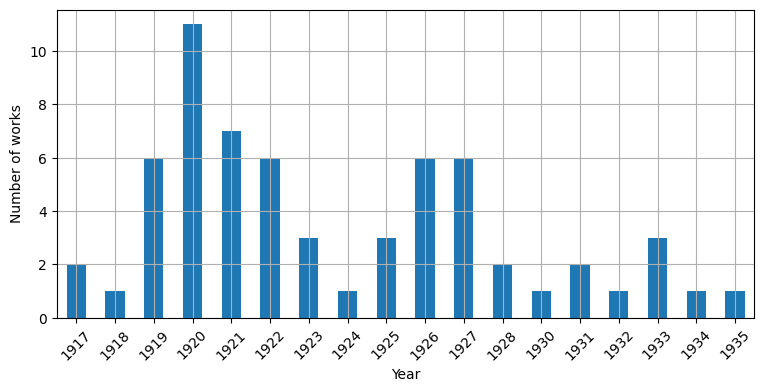

In [31]:
accessor = df.groupby("Year")["Story Name"].count().plot(ylabel="Number of works", figsize=(9, 4), kind="bar", grid=True, rot=45)

In [32]:
# details of picking the model for topic modeling:
    # we've tried using more automatic, more recent, topic modeling tools like Top2Vec and BERTopic
        # but our corpus proved to be too small for those models to work on it
    # going with the more traditional topic-modeling method: LDA
        # we've tried to find the most suitable number of topics by maximizing the coherence score of our topic model
            # optimized number of passes and iterations for maximum possible convergence of the algorithm

In [33]:
#add lexical diversity score
def get_lexical_diversity(doc):
    words = [token.text.lower() for token in doc if token.is_alpha]
    unique_words = set(words)
    diversity = len(unique_words) / len(words)
    
    return diversity


#df["lex_div"]=df["Tokens"].apply(lexical_diversity)


In [34]:
def get_mean_word_length(doc):
    words = [token.text.lower() for token in doc if token.is_alpha]
    mean_length = sum(len(word) for word in words) / len(words)
    return mean_length


#df["mean word length"]=df["Tokens"].apply(mean_word_length)

In [35]:
def get_mean_sentence_length(doc):
    sentences = [list(sent) for sent in doc.sents]
    mean_length = sum(len(sent) for sent in sentences) / len(sentences)
    return mean_length


#df["mean sentence length"]=df["Tokens"].apply(mean_sentence_length)

In [36]:
def get_stdev_sentence_length(doc):
    sentences = [list(sent) for sent in doc.sents]
    std_dev_length = np.std([len(sent) for sent in sentences])
    return std_dev_length

#df["stdev sentence length"]=df["Tokens"].apply(stdev_sentence_length)

In [37]:
def segment_into_paragraphs(doc):
    paragraphs = []
    current_paragraph = []
    
    for token in doc:
        if token.is_space and token.text == '\n':
            if current_paragraph:
                paragraphs.append(current_paragraph)
                current_paragraph = []
        else:
            current_paragraph.append(token)
    
    if current_paragraph:
        paragraphs.append(current_paragraph)
    
    return paragraphs

In [38]:
def get_stdev_paragraph_length(doc):
    paragraphs = segment_into_paragraphs(doc)
    paragraph_lengths = [len(paragraph) for paragraph in paragraphs]
    std_dev_length = np.std(paragraph_lengths)
    return std_dev_length


#df["mean paragraph length"]=df["Tokens"].apply(mean_paragraph_length)

In [39]:
def get_mean_paragraph_length(doc):
    paragraphs = segment_into_paragraphs(doc)
    paragraph_lengths = [len(paragraph) for paragraph in paragraphs]
    mean_length = np.mean(paragraph_lengths)
    return mean_length


#df["stdev paragraph length"]=df["Tokens"].apply(mean_paragraph_length)

In [40]:
def get_document_length(doc):
    num_words = len([token for token in doc if token.is_alpha])
    return num_words

#df["document length"]=df["Tokens"].apply(document_length)

In [41]:
def get_phraseology_feature_vec(doc):
    vector=[]
    mean_word_length=get_mean_word_length(doc)
    mean_sentence_length=get_mean_sentence_length(doc)
    stdev_sentence_length=get_stdev_sentence_length(doc)
    mean_paragraph_length=get_mean_paragraph_length(doc)
    stdev_paragraph_length=get_stdev_paragraph_length(doc)
    document_length=get_document_length(doc)
    vector=[
        mean_word_length,
        mean_sentence_length,
        stdev_sentence_length,
        mean_paragraph_length,
        stdev_paragraph_length,
        document_length
    ]

    return np.array(vector)

In [42]:
def get_punct_vector(doc):

    punctuation_table = [',', ';', '"', '!', ':', '-', '--', '?', '!']
    punctuation_counts = {punct: 0 for punct in punctuation_table}
    
    for token in doc:
        if token.is_punct and token.text in punctuation_table:
            punctuation_counts[token.text] += 1
    
    vector = []
    for punct in punctuation_table:
        vector.append(punctuation_counts[punct])

    #vector=vector/np.sum(vector)
    #norm = np.sqrt(np.sum(np.square(vector)))
    #normalized_vector = vector / norm
    
    return np.array(vector)#normalized_vector

In [43]:
def get_lex_vector(doc):

    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    stopwords_counts = {word: 0 for word in stopwords}
    
    for token in doc:
        if token.text.lower() in stopwords:
            stopwords_counts[token.text.lower()] += 1
    
    vector = np.array([stopwords_counts[word] for word in stopwords])
    
    #vector=vector/np.sum(vector)
    #norm = np.sqrt(np.sum(np.square(vector)))
    #normalized_vector = vector / norm

    return vector #normalized_vector

In [44]:
df["phraseology vector"] = df["Tokens"].apply(get_phraseology_feature_vec)
df["punct vector"] = df["Tokens"].apply(get_punct_vector)
df["lex vector"] = df["Tokens"].apply(get_lex_vector)

In [45]:
df["features"] = list(np.hstack([
    np.array(df["phraseology vector"].to_list()),
    np.array(df["punct vector"].to_list()),
    np.array(df["lex vector"].to_list()),
]))

In [46]:
df[ ["Story Name", "Year", "Tokens", "phraseology vector", "punct vector", "lex vector", "features"] ].head()

,Story Name,Year,Tokens,phraseology vector,punct vector,lex vector,features
0,The Tomb,1917,"(\n, In, relating, the, circumstances, which, ...","[4.443165467625899, 31.48076923076923, 14.3278...","[184, 51, 6, 13, 3, 29, 0, 5, 13]","[0, 15, 2, 1, 0, 0, 0, 0, 12, 0, 2, 1, 7, 1, 2...","[4.443165467625899, 31.48076923076923, 14.3278..."
1,Dagon,1917,"(\n, I, am, writing, this, under, an, apprecia...","[4.456171735241503, 31.297619047619047, 15.924...","[109, 28, 0, 3, 0, 17, 0, 0, 3]","[0, 5, 0, 1, 0, 0, 0, 1, 10, 0, 5, 1, 0, 1, 1,...","[4.456171735241503, 31.297619047619047, 15.924..."
2,Polaris,1918,"(\n, Into, the, north, window, of, my, chamber...","[4.301639344262295, 35.01923076923077, 22.4657...","[101, 12, 6, 0, 2, 10, 0, 1, 0]","[0, 2, 0, 3, 0, 0, 0, 0, 11, 0, 2, 0, 4, 0, 1,...","[4.301639344262295, 35.01923076923077, 22.4657..."
3,Beyond the Wall of Sleep,1919,"(\n, "", /, have, an, exposition, of, sleep, co...","[4.624136342699217, 33.12820512820513, 15.9517...","[234, 42, 13, 2, 1, 39, 0, 8, 2]","[0, 12, 0, 4, 0, 0, 0, 1, 15, 0, 6, 0, 10, 1, ...","[4.624136342699217, 33.12820512820513, 15.9517..."
4,Memory,1919,"(\n, In, the, valley, of, Nis, the, accursed, ...","[4.267605633802817, 25.11764705882353, 8.96976...","[25, 0, 4, 0, 0, 2, 0, 0, 0]","[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[4.267605633802817, 25.11764705882353, 8.96976..."


In [47]:
# from matplotlib.pyplot import figure

# figure(figsize=(9, 4))

# plt.plot(df["Year"].value_counts(sort=False))
# plt.xticks(np.arange(df["Year"].min(), df["Year"].max()+1, 1), rotation=45)
# plt.grid()
# plt.title("Works by year")
# plt.xlabel("year")
# plt.ylabel("number of works")
# _ = plt.show()

In [48]:
# assign regular labels
# plot, coloring according to labels
# see if can train logistic regression or svm

In [49]:
# X = np.array(df["phraseology vector"].to_list())
# df["phraseology vector z-score"] = list(np.apply_along_axis(lambda column: column/np.linalg.norm(column), 0, X))
# df["phraseology vector l2 normalized"] = list(np.apply_along_axis(lambda column: (column - column.mean()) / column.std(), 0, X))
# del X
# df[["phraseology vector", "phraseology vector z-score", "phraseology vector l2 normalized"]].head()


def l2_normalize(column):
    return (column - column.mean()) \
        / (column.std() + np.finfo(np.float64).eps)
    
def zscore_normalize(column):
    return column \
        / (np.linalg.norm(column) + np.finfo(np.float64).eps)
        
def minmax_normalize(column):
    return (column - column.min()) / (column.max() - column.min() + np.finfo(np.float64).eps)

X = np.array(df["features"].to_list())

df["features z-score"] = list(np.apply_along_axis(zscore_normalize, 0, X))
df["features l2 normalized"] = list(np.apply_along_axis(l2_normalize, 0, X))
df["features minmax normalized"] = list(np.apply_along_axis(minmax_normalize, 0, X))
del X

df[["features", "features z-score", "features l2 normalized", "features minmax normalized"]]

,features,features z-score,features l2 normalized,features minmax normalized
0,"[4.443165467625899, 31.48076923076923, 14.3278...","[0.12426974982818584, 0.121115769317718, 0.106...","[-0.3556951140339453, -0.18892659128933037, -0...","[0.4577662652227031, 0.41365860649863845, 0.29..."
1,"[4.456171735241503, 31.297619047619047, 15.924...","[0.12463351877502478, 0.12041113674758264, 0.1...","[-0.2765362030998336, -0.22694431849632546, -0...","[0.475524042772693, 0.40634624890680254, 0.383..."
2,"[4.301639344262295, 35.01923076923077, 22.4657...","[0.12031144215931895, 0.13472927057273335, 0.1...","[-1.2170532011726132, 0.5455758983498166, 1.75...","[0.26453716287912954, 0.554933355172908, 0.744..."
3,"[4.624136342699217, 33.12820512820513, 15.9517...","[0.1293312775915364, 0.12745393928608567, 0.11...","[0.7457321212792094, 0.1530428649375923, -0.20...","[0.7048502586908717, 0.4794332630372025, 0.385..."
4,"[4.267605633802817, 25.11764705882353, 8.96976...","[0.11935956208297688, 0.09663496862735314, 0.0...","[-1.4241896014560538, -1.5097630696205975, -2....","[0.2180700996599218, 0.159607947517575, 0.0, 0..."
...,...,...,...,...
58,"[4.39846139586616, 23.76156583629893, 13.63792...","[0.12301943316670608, 0.09141772570296972, 0.1...","[-0.627773602606336, -1.7912540575176368, -0.8...","[0.39673069488460794, 0.10546576402577579, 0.2..."
59,"[4.257460503218256, 21.12, 12.223158347988461,...","[0.11907581554035908, 0.08125484575167417, 0.0...","[-1.4859350239010547, -2.3395818158436072, -1....","[0.20421870297482686, 0.0, 0.17940423669316452..."
60,"[4.323704333050127, 30.17391304347826, 11.6885...","[0.1209285721439222, 0.11608790956781513, 0.08...","[-1.0827609865388939, -0.46019960435785257, -1...","[0.29466303558278556, 0.3614817557949798, 0.14..."
61,"[4.669605604975203, 29.1395793499044, 15.45973...","[0.1306029956693527, 0.11210852392732727, 0.11...","[1.0224677220772882, -0.6749032728278428, -0.3...","[0.7669305624892079, 0.3201854944066169, 0.357..."


In [50]:
SEED = 654321
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### 3-period classification

In [51]:
early_writings_period = (df['Year'] >= 1917) & (df['Year'] <= 1922)
mid_writings_period = (df['Year'] >= 1925) & (df['Year'] <= 1928)
late_writings_period = (df['Year'] >= 1931) & (df['Year'] <= 1935)
# early_writings_period = (df['Year'] >= 1917) & (df['Year'] <= 1922)
# mid_writings_period = (df['Year'] >= 1926) & (df['Year'] <= 1934)
# late_writings_period = (df['Year'] >= 1934) & (df['Year'] <= 1935)

df.loc[early_writings_period, "label"] = 0
df.loc[mid_writings_period, "label"] = 1
df.loc[late_writings_period, "label"] = 2

df["label"] = df["label"].interpolate().round().astype(np.int64)

In [52]:
I3 = np.identity(df["label"].unique().size)

def to_onehot3(number):
    return I3[number]
    
def to_class(onehot:np.ndarray):
    return onehot.argmax(axis=1)
    
df["one-hot label"] = list(to_onehot3(df["label"]))
df["one-hot label"]

# sanity
assert all(df["label"] == to_class(np.array(df["one-hot label"].to_list())))

In [53]:
early_writings = df[early_writings_period]
mid_writings = df[mid_writings_period]
late_writings = df[late_writings_period]

(y := df["label"])

0     0
1     0
2     0
3     0
4     0
     ..
58    2
59    2
60    2
61    2
62    2
Name: label, Length: 63, dtype: int64

In [54]:
train_df = list()
test_df = list()

for data in (early_writings, mid_writings, late_writings):
    train = data.sample(frac=0.66)
    test = data.drop(train.index) 
    
    train_df.append(train)
    test_df.append(test)
    
    # print(f"{train.shape = }")
    # print(f"{test.shape = }")
    # print(f"{pd.concat(train_data).shape = }")
    # print(f"{pd.concat(test_data).shape = }")
    # print()
    
train_df = pd.concat(train_df)
test_df = pd.concat(test_df)
print(f"{train_df.shape = }")
print(f"{test_df.shape = }")

train_df.shape = (38, 16)
test_df.shape = (20, 16)


In [55]:
used_vector_type = "features z-score"

# used_vector_type = "features l2 normalized"
# used_vector_type = "features minmax normalized"

# used_vector_type = "phraseology vector l2 normalized"
# used_vector_type = "phraseology vector z-score"
# used_vector_type = "phraseology vector"

In [56]:
def evaluate(model:nn.Module, loss_fn, train_df_arg, test_df_arg):
    labels_max = test_df_arg["one-hot label"].iloc[0].size
    
    label_indices = list(
        (test_df_arg.reset_index().query(f"label == {i}")).index 
        for i in range(labels_max)
    )
    
    previous_state = model.training
    model.eval()
    
    with torch.no_grad():
        test_y_pred = model(
            torch.tensor(test_df_arg[used_vector_type].to_list()).float()
        )
        train_y_pred = model(
            torch.tensor(train_df_arg[used_vector_type].to_list()).float()
        )
        
        train_accuracy = (
            to_class(
                train_y_pred
            ) == torch.tensor(train_df_arg["label"].values)
        ).sum() / train_df_arg["label"].size
        
        test_accuracy = (
            to_class(
                test_y_pred
            ) == torch.tensor(test_df_arg["label"].values)
        ).sum() / test_df_arg["label"].size
        
        test_label_accuracy = list(
            (
                to_class(
                    test_y_pred[ label_indices[i] ]
                ) == i
            ).sum() / label_indices[i].size
            
            for i in range(labels_max)
        )
        
        train_loss = loss_fn(train_y_pred, torch.tensor(train_df_arg["label"].values))
        test_loss = loss_fn(test_y_pred, torch.tensor(test_df_arg["label"].values))
        
    model.train(previous_state)
    
    return train_accuracy, test_accuracy, train_loss, test_loss, test_label_accuracy

In [57]:
def plot_training_process(train_accuracies, test_accuracies, train_losses, test_losses, 
        test_0_accuracies, test_1_accuracies, test_2_accuracies=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,)

    fig.set_figwidth(22)
    fig.set_figheight(4)

    ax1.plot(train_losses, label="train loss")
    ax1.plot(test_losses, label="test loss")
    ax1.text(len(train_losses), train_losses[-1], f"{train_losses[-1]:0.1f}")
    ax1.text(len(test_losses), test_losses[-1], f"{test_losses[-1]:0.1f}")
    ax1.set_xlabel("iterations")
    ax1.set_ylabel("loss")
    ax1.legend(loc='upper left', framealpha=1)
    # ax1.show()

    ax2.plot(train_accuracies, label="train accuracy")
    ax2.plot(test_accuracies, label="test accuracy")
    ax2.text(len(train_accuracies), train_accuracies[-1], f"{train_accuracies[-1]:0.2f}")
    ax2.text(len(test_accuracies), test_accuracies[-1], f"{test_accuracies[-1]:0.2f}")
    ax2.set_xlabel("iterations")
    ax2.set_ylabel("accuracy")
    ax2.legend(loc='upper left', framealpha=1)
    # plt.show()

    ax3.plot(test_0_accuracies, label="test label 0 accuracy")
    ax3.plot(test_1_accuracies, label="test label 1 accuracy")
    ax3.text(len(test_0_accuracies), test_0_accuracies[-1], f"{test_0_accuracies[-1]:0.2f}")
    ax3.text(len(test_1_accuracies), test_1_accuracies[-1], f"{test_1_accuracies[-1]:0.2f}")
    if test_2_accuracies is not None:
        ax3.plot(test_2_accuracies, label="test label 2 accuracy")
        ax3.text(len(test_2_accuracies), test_2_accuracies[-1], f"{test_2_accuracies[-1]:0.2f}")
    ax3.set_xlabel("iterations")
    ax3.set_ylabel("accuracy")
    ax3.legend(loc='upper left', framealpha=1)
    # fig.show()
    # plt.show()

In [58]:
def train_model(train_df, test_df, n_epochs=500, factor=1, hidden_layers_num=0, dropout_p=0.5, lr=1e-3):
    # print(f"{used_vector_type = }")
    
    datapoint_size = train_df[used_vector_type].iloc[0].shape[0]
    # print(f"{datapoint_size = }")
    labels_max = train_df["one-hot label"].iloc[0].size
    # print(f"{labels_max = }")
    
    layers = []
    for _ in range(hidden_layers_num):
        layers.append(nn.Linear(factor * datapoint_size, factor * datapoint_size))
        layers.append(nn.ReLU())

    # define model architecture
    model = nn.Sequential(
        nn.Linear(datapoint_size, factor * datapoint_size),
        nn.ReLU(),
        
        *layers,
        
        nn.Dropout(p=dropout_p),
        nn.Linear(factor * datapoint_size, labels_max),
        # nn.ReLU(),
    )
    # print(f"{model = }")

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    Xtrain = torch.tensor(train_df[used_vector_type].to_list()).float()
    ytrain = torch.tensor(train_df["one-hot label"].to_list()).float()

    train_losses = list()
    test_losses = list()
    train_accuracies = list()
    test_accuracies = list()
    test_label_accuracies = list(list() for _ in range(labels_max))

    for epoch in range(n_epochs):
        indices = torch.randperm(Xtrain.shape[0])
        Xtrain = Xtrain[indices]
        ytrain = ytrain[indices]
        
        Xbatch = Xtrain
        ybatch = ytrain

        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update weights
        optimizer.step()
        
        train_accuracy, test_accuracy, train_loss, test_loss, \
            test_label_accuracy = evaluate(model, loss_fn, train_df, test_df)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        for i in range(labels_max):
            test_label_accuracies[i].append(test_label_accuracy[i])

    return train_accuracies, test_accuracies, train_losses, test_losses, \
        *test_label_accuracies, model

c:\Users\SB\.conda\envs\nlp10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\SB\AppData\Local\Temp\ipykernel_13448\881674369.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:277.)
  Xtrain = torch.tensor(train_df[used_vector_type].to_list()).float()


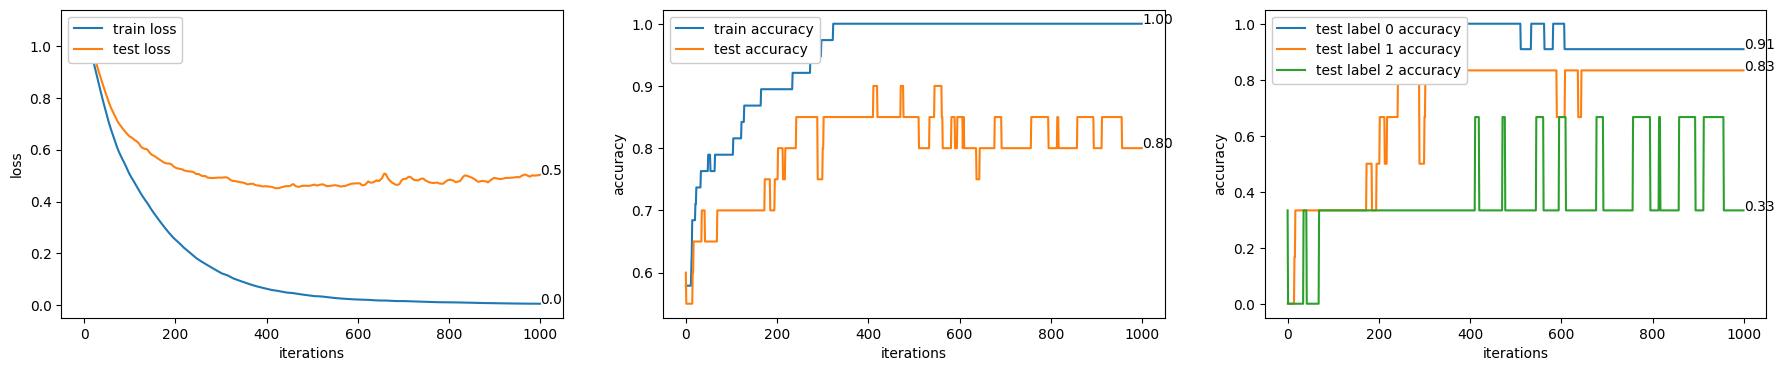

In [59]:
preferred_n_epochs = 1000
preferred_factor = 3
preferred_layers_num = 0
preferred_dropout_p = 0.95
preferred_lr = 0.001

# while True:
train_accuracies, test_accuracies, train_losses, test_losses, \
    test_0_accuracies, test_1_accuracies, test_2_accuracies, model = \
        train_model(
            train_df,
            test_df,
            n_epochs=preferred_n_epochs,
            factor=preferred_factor,
            hidden_layers_num=preferred_layers_num,
            dropout_p=preferred_dropout_p, 
            lr=preferred_lr,
        )

    # if test_accuracies[-1] > 0.79:
    #     break

plot_training_process(train_accuracies, test_accuracies, train_losses, test_losses, \
    test_0_accuracies, test_1_accuracies, test_2_accuracies)

### 2-period classification

In [60]:
early_writings_period2 = (df['Year'] >= 1917) & (df['Year'] <= 1924)
late_writings_period2 = (df['Year'] >= 1926) & (df['Year'] <= 1935)

df_2_periods = df[early_writings_period2 | late_writings_period2].copy()

df_2_periods.loc[early_writings_period2, "label"] = 0
df_2_periods.loc[late_writings_period2, "label"] = 1

df_2_periods["label"] = df_2_periods["label"].astype(np.int64)

In [61]:
I2 = np.identity(df_2_periods["label"].unique().size)

def to_onehot2(number):
    return I2[number]
    
df_2_periods["one-hot label"] = list(to_onehot2(df_2_periods["label"]))
df_2_periods["one-hot label"]

# sanity
assert all(df_2_periods["label"] == to_class(np.array(df_2_periods["one-hot label"].to_list())))

In [62]:
early_writings2 = df_2_periods.query("Year >= 1917 and Year <= 1924")
late_writings2 = df_2_periods.query("Year >= 1926 and Year <= 1935")

In [63]:
train_df2 = list()
test_df2 = list()

for data in (early_writings2, late_writings2):
    train = data.sample(frac=0.66)
    test = data.drop(train.index) 
    
    train_df2.append(train)
    test_df2.append(test)
    
    # print(f"{train.shape = }")
    # print(f"{test.shape = }")
    # print(f"{pd.concat(train_data).shape = }")
    # print(f"{pd.concat(test_data).shape = }")
    # print()
    
train_df2 = pd.concat(train_df2)
test_df2 = pd.concat(test_df2)
print(f"{train_df2.shape = }")
print(f"{test_df2.shape = }")

train_df2.shape = (39, 16)
test_df2.shape = (21, 16)


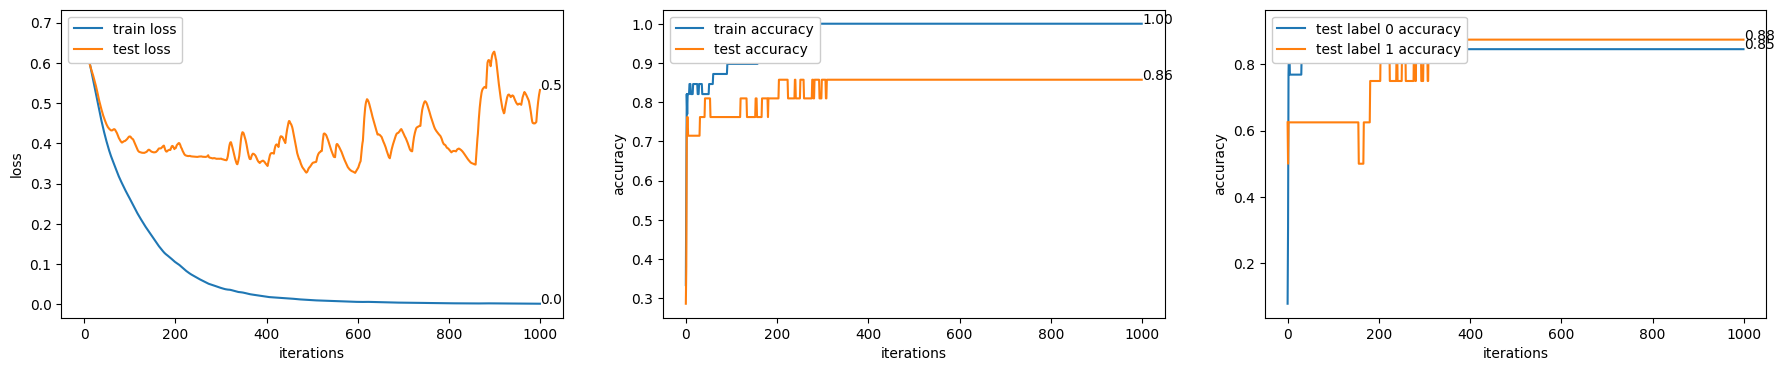

In [64]:
preferred_n_epochs = 1000
preferred_factor = 3
preferred_layers_num = 0
preferred_dropout_p = 0.95
preferred_lr = 0.001

# while True:
train_accuracies, test_accuracies, train_losses, test_losses, \
    test_0_accuracies, test_1_accuracies, model = \
        train_model(
            train_df2,
            test_df2,
            n_epochs=preferred_n_epochs,
            factor=preferred_factor,
            hidden_layers_num=preferred_layers_num,
            dropout_p=preferred_dropout_p, 
            lr=preferred_lr,
        )

    # if test_accuracies[-1] > 0.79:
    #     break

plot_training_process(train_accuracies, test_accuracies, train_losses, test_losses, \
    test_0_accuracies, test_1_accuracies)

#### Logistic regression model

In [65]:
early_writings = df[(df['Year'] >= 1919) & (df['Year'] <= 1922)]
early_writings["Stage"]="0"

mid_writings = df[(df['Year'] >= 1925) & (df['Year'] <= 1928) & (df["Story Name"]!="The Case of Charles Dexter Ward")]
mid_writings["Stage"]="1"

late_writings = df[(df['Year'] >= 1931) & (df['Year'] <= 1935)]
late_writings["Stage"]="2"

C:\Users\SB\AppData\Local\Temp\ipykernel_13448\1762026649.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_writings["Stage"]="0"
C:\Users\SB\AppData\Local\Temp\ipykernel_13448\1762026649.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid_writings["Stage"]="1"
C:\Users\SB\AppData\Local\Temp\ipykernel_13448\1762026649.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [66]:
dfs = [early_writings, mid_writings, late_writings]  

lab_df = pd.concat(dfs, ignore_index=True)

In [67]:
lab_df["phraseology vector"]=df["Tokens"].apply(get_phraseology_feature_vec)

In [68]:
lab_df["punct vector"]=df["Tokens"].apply(get_punct_vector)

In [69]:
lab_df["lex vector"]=df["Tokens"].apply(get_lex_vector)

In [70]:
# lab_df.head()

In [71]:
X = np.array(lab_df["phraseology vector"].to_list())
lab_df["phraseology vector z-score"] = list(np.apply_along_axis(lambda column: column/np.linalg.norm(column), 0, X))
lab_df["phraseology vector l2 normalized"] = list(np.apply_along_axis(lambda column: (column - column.mean()) / column.std(), 0, X))
del X
lab_df[["phraseology vector", "phraseology vector z-score", "phraseology vector l2 normalized"]].head()

,phraseology vector,phraseology vector z-score,phraseology vector l2 normalized
0,"[4.443165467625899, 31.48076923076923, 14.3278...","[0.13439740190611732, 0.12836872809329583, 0.1...","[-0.33142805685527277, -0.33677809883202636, -..."
1,"[4.456171735241503, 31.297619047619047, 15.924...","[0.13479081704871537, 0.127621898945358, 0.125...","[-0.24992143386426713, -0.37616160106236823, -..."
2,"[4.301639344262295, 35.01923076923077, 22.4657...","[0.13011650275426187, 0.14279746723145492, 0.1...","[-1.2183324879571842, 0.4241111642581811, 1.63..."
3,"[4.624136342699217, 33.12820512820513, 15.9517...","[0.13987143063805338, 0.13508645627899674, 0.1...","[0.8026655450061587, 0.01747650372990097, -0.2..."
4,"[4.267605633802817, 25.11764705882353, 8.96976...","[0.12908704699883108, 0.10242190659324953, 0.0...","[-1.431612184284349, -1.7050652167611884, -2.3..."


Logistic Regression

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

All features

In [73]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# X = np.array(lab_df["features l2 normalized"].to_list())
# y = lab_df['Stage']  # Extract stage labels


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=42)

# # Instantiate Logistic Regression model
# model = LogisticRegression(solver="liblinear", max_iter=1_000)

# # Train the model
# model.fit(X_train, y_train)

# # Make predictions
# predictions = model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy:", accuracy)

# predictions

Phras Logistic

In [74]:
X = np.array(lab_df["phraseology vector"].to_list())
y = lab_df['Stage']  # Extract stage labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=42)

# Instantiate Logistic Regression model
model = LogisticRegression(solver="liblinear", max_iter=1_000)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

phras_acc = accuracy_score(y_test, predictions)

predictions

Accuracy: 0.6470588235294118


array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0',
       '0', '0', '0', '2'], dtype=object)

Punct Logistic

In [75]:
X = np.array(lab_df["punct vector"].to_list())
y = lab_df['Stage']  # Extract stage labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=42)

# Instantiate Logistic Regression model
model = LogisticRegression(solver="liblinear", max_iter=1_000)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

punct_acc = accuracy_score(y_test, predictions)

predictions

Accuracy: 0.5294117647058824


array(['0', '0', '0', '0', '0', '0', '0', '1', '0', '2', '0', '0', '2',
       '2', '1', '1', '0'], dtype=object)

Lex Logistic

In [76]:
X = np.array(lab_df["lex vector"].to_list())
y = lab_df['Stage']  # Extract stage labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=42)

# Instantiate Logistic Regression model
model = LogisticRegression(solver="liblinear", max_iter=1_000)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

lex_acc = accuracy_score(y_test, predictions)

predictions

Accuracy: 0.7058823529411765


array(['0', '1', '0', '1', '1', '1', '1', '0', '1', '2', '0', '0', '1',
       '0', '0', '0', '0'], dtype=object)

Phras+Punct Features

In [77]:
def phras_punct(row):
    return np.concatenate((row['phraseology vector'], row['punct vector']))

lab_df['phras_punct'] = lab_df.apply(phras_punct, axis=1)

In [78]:
X = np.array(lab_df["phras_punct"].to_list())
y = lab_df['Stage']  # Extract stage labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=42)

# Instantiate Logistic Regression model
model = LogisticRegression(solver="liblinear", max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

phras_punct_acc = accuracy_score(y_test, predictions)

predictions

Accuracy: 0.7058823529411765


array(['0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1',
       '1', '1', '0', '0'], dtype=object)

Lex+Phras Features

In [79]:
def phras_lex(row):
    return np.concatenate((row['lex vector'], row['phraseology vector']))

lab_df['phras_lex'] = lab_df.apply(phras_lex, axis=1)

In [80]:
X = np.array(lab_df["phras_lex"].to_list())
y = lab_df['Stage']  # Extract stage labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=42)

# Instantiate Logistic Regression model
model = LogisticRegression(solver="liblinear", max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

phras_lex_acc = accuracy_score(y_test, predictions)

predictions

Accuracy: 0.7058823529411765


array(['0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '0', '1', '2',
       '0', '0', '1', '0'], dtype=object)

Lex+Punct

In [81]:
def lex_punct(row):
    return np.concatenate((row['lex vector'], row['punct vector']))

lab_df['lex_punct'] = lab_df.apply(phras_lex, axis=1)

In [82]:
X = np.array(lab_df["lex_punct"].to_list())
y = lab_df['Stage']  # Extract stage labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=42)

# Instantiate Logistic Regression model
model = LogisticRegression(solver="liblinear", max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

lex_punct_acc = accuracy_score(y_test, predictions)

predictions

Accuracy: 0.7647058823529411


array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '0', '0'], dtype=object)

lex+Punct+Phras

In [83]:
def lex_punct_phras(row):
    return list(row['lex vector']) + list(row['punct vector'])+ list(row['phraseology vector'])

lab_df['lex_punct_phras'] = lab_df.apply(lex_punct, axis=1)

In [84]:
X = np.array(lab_df["lex_punct_phras"].to_list())
y = lab_df['Stage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LogisticRegression(solver="liblinear", max_iter=1_000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
all_acc = accuracy_score(y_test, predictions)
#print("Accuracy:", accuracy)

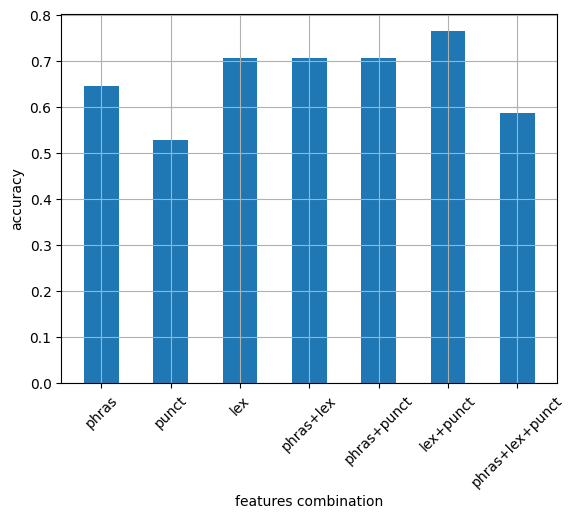

In [85]:
values = [phras_acc,punct_acc, lex_acc, phras_lex_acc, phras_punct_acc,lex_punct_acc, all_acc]
value_names = ["phras", "punct", "lex", "phras+lex", "phras+punct", "lex+punct", "phras+lex+punct"]

plt.bar(range(len(values)), values, tick_label=value_names, width=0.5)
plt.xticks(rotation=45)
plt.xlabel('features combination')
plt.ylabel('accuracy')
plt.grid()
# plt.title('Bar Graph with Value Names')

plt.show()
